# TD-DFT sampling analysis

In [1]:
# Modules are loaded

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import glob
from scipy.constants import e, h, c, k
from scipy.stats import norm

In [2]:
# plots global parameters
plt.rcParams["figure.dpi"] = 100
plt.rcParams['figure.figsize'] = [9, 6]

Creating UV/Visible Plots from the Results of Excited States Calculations

$$\varepsilon_i(\tilde{\nu}) = \varepsilon_i^{{max}}\left[-\left(\frac{\tilde{\nu} - \tilde{\nu}_i}{\sigma}\right)^2\right] $$


[reference](https://gaussian.com/uvvisplot/)

In [3]:
# Some definitions and conversions
#---------------------------------

# Vector with wavelength values (in nm)
w_nm = np.linspace(100, 800, num=1401)

# Hatree to kJ/mol
Ha_to_kJmol = 2625.5

# Hatree to J
Ha_to_J = 4.359748199e-18


In [5]:
# Some functions
#---------------

def read_UVVis(file):
    """Reads the UV-Vis spectrum data from a Gaussian output."""
    
    ExcitedE = re.compile(r"""
        ^\sExcited\sState\s+(?P<Nstate>\d+):\s+\w+-\w\s+(?P<E>\d+.\d+)\seV\s+(?P<wl>\d+.\d+)\snm\s+f=(?P<f>\d+.\d+)
    """, re.X)

    Transitions = re.compile(r"""
        ^\s+(?P<states>\d+\s->\s\d+)\s+(?P<p>[+-]?\d+\.\d+)
    """, re.X)
    
    state = 0
    UVVis = {}
    with open(file, "r") as f:
        UVVis["states"] = {}
        UVVis["transition"] = {}
        for line in f:
            if ExcitedE.match(line):
                m = ExcitedE.match(line)
                state = int(m.groupdict()["Nstate"])
                # print(m.groupdict())
                UVVis["states"][state] = m.groupdict()
                UVVis["transition"][state] = []
        
            elif Transitions.match(line):
                m = Transitions.match(line)
                # print(m.groupdict())
                UVVis["transition"][state].append(m.groupdict())
                
    transition = UVVis["transition"]
    for n in transition:
        tab = pd.DataFrame(transition[n])
        tab = tab.astype({"p": np.float64})
        tab["test"] = tab["p"]**2
    
        ou = tab[tab["test"] == tab["test"].max()].values[0][0:-1]
        UVVis["states"][n]["t"] = ou[0]
        UVVis["states"][n]["p"] = ou[1]
        
    table = []
    for i in UVVis["states"]:
        table.append(UVVis["states"][i])
        
    table = pd.DataFrame(table)
    table = table.astype({
        "E": np.float64,
        "wl": np.float64,
        "f": np.float64,
        "Nstate": np.int64
    })
    

    return table


def epsilon_i(wl, wl_i, f, sigma=0.4):
    """
    Parameters:
    -----------
    sigma : float
        eV
    """
    
    # Convert to cm-1
    sigma_cm = (sigma * 1e-2 * e / h / c)
    sigma_nm = (sigma * 1e-9 * e / h / c)
    
    return 1.3062974e8 * (f / sigma_cm) * np.exp(-((((1/wl) - (1/wl_i))/(sigma_nm))**2))


def epsilon_tot(wl, table, sigma=0.4, normalize=False):
    
    try:
        eps = np.zeros(len(wl))
    except TypeError:
        eps = 0.0

    for i in table.index:
        eps += epsilon_i(wl, table.loc[i, "wl"], table.loc[i, "f"])
        
    if normalize:
        eps = eps / eps.max()
        
    return eps


def dnorm(values):
    return norm.pdf(values, values.mean(), values.std())


boxText = {
        "facecolor": "0.85",
        "edgecolor": "k",
        "boxstyle": "round"
    }


def get_spectre_info(logs_files):
    
    data = {}
    
    for i, file in enumerate(logs_files):
        data[i] = read_UVVis(file)
        
    print("Number of files analyzed:", len(data))
    
    spectra = []
    w_s1 = []
    w_s2 = []
    for i in data:
        spectra.append(epsilon_tot(w_nm, data[i]))
        w_s1.append(data[i].loc[0, "wl"])
        w_s2.append(data[i].loc[1, "wl"])
        
    spectra = np.array(spectra).mean(axis=0)
    w_s1 = np.array(w_s1)
    w_s2 = np.array(w_s2)
    
    return spectra, w_s1, w_s2
    

## UV-Vis THF

In [6]:
%%time
# cis in CHX
cis_chx_spectra, cis_chx_w_s1, cis_chx_w_s2 = get_spectre_info(
    glob.glob("../exp.azobO.thf/azob_cis.chx/md/SamplingUV-Vis_*/*.log")
)

Number of files analyzed: 400
CPU times: user 6.78 s, sys: 124 ms, total: 6.9 s
Wall time: 12.1 s


In [7]:
%%time
# trans in CHX
trans_chx_spectra, trans_chx_w_s1, trans_chx_w_s2 = get_spectre_info(
    glob.glob("../exp.azobO.thf/azob_trans.chx/md/SamplingUV-Vis_*/*.log")
)

Number of files analyzed: 400
CPU times: user 6.8 s, sys: 65.8 ms, total: 6.86 s
Wall time: 11.2 s


In [8]:
%%time
# cis in THF
cis_thf_spectra, cis_thf_w_s1, cis_thf_w_s2 = get_spectre_info(
    glob.glob("../exp.azobO.thf/azob_cis.thf/md/SamplingUV-Vis_*/*.log")
)

Number of files analyzed: 400
CPU times: user 6.85 s, sys: 208 ms, total: 7.05 s
Wall time: 12.7 s


In [9]:
%%time
# trans in THF
trans_thf_spectra, trans_thf_w_s1, trans_thf_w_s2 = get_spectre_info(
    glob.glob("../exp.azobO.thf/azob_trans.thf/md/SamplingUV-Vis_*/*.log")
)

Number of files analyzed: 400
CPU times: user 6.81 s, sys: 61.3 ms, total: 6.87 s
Wall time: 13.6 s


In [10]:
%%time
# cis in polybutadiene

cis_pol_spectra, cis_pol_w_s1, cis_pol_w_s2 = get_spectre_info(
    glob.glob("../sendme/azoOC/*/*.log") + glob.glob("../sendme/azoOC_long/*/*.log")
)


Number of files analyzed: 800
CPU times: user 13.5 s, sys: 157 ms, total: 13.7 s
Wall time: 25.5 s


In [11]:
%%time
# trans in polybutadiene

trans_pol_spectra, trans_pol_w_s1, trans_pol_w_s2 = get_spectre_info(
    glob.glob("../sendme/azoOT/*/*.log") + glob.glob("../sendme/azoOT_long/*/*.log")
)


Number of files analyzed: 800
CPU times: user 13.8 s, sys: 147 ms, total: 14 s
Wall time: 25.1 s


In [12]:
dataW = {
    "THF": {
        "cis": {
            "s1": cis_thf_w_s1,
            "s2": cis_thf_w_s2
        },
        "trans": {
            "s2": trans_thf_w_s2
        }
    },
    "Polybutadiene": {
        "cis": {
            "s1": cis_pol_w_s1,
            "s2": cis_pol_w_s2
        },
        "trans": {
            "s2": trans_pol_w_s2
        }
    },
    "Cyclohexane": {
        "cis": {
            "s1": cis_chx_w_s1,
            "s2": cis_chx_w_s2
        },
        "trans": {
            "s2": trans_chx_w_s2
        }
    }
}

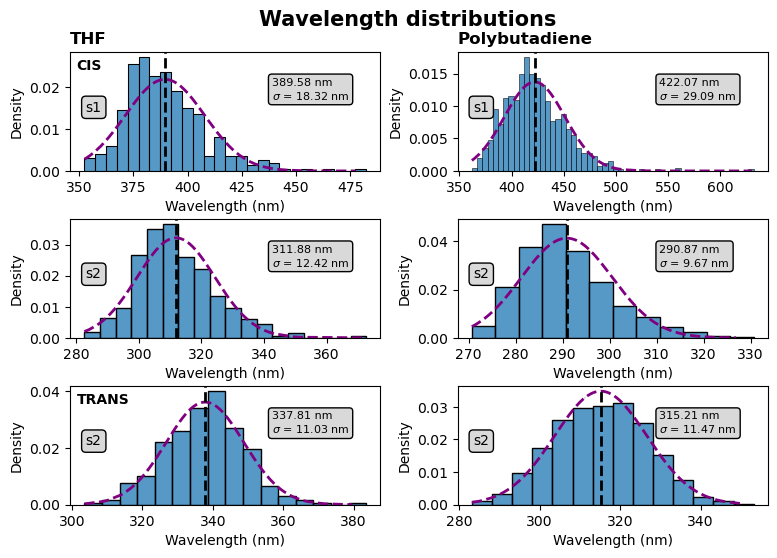

In [95]:
fig, ax = plt.subplots(nrows=3, ncols=2)

fig.subplots_adjust(hspace=0.4, wspace=0.25)

fig.suptitle(
    "Wavelength distributions",
    fontweight="bold",
    fontsize=15,
    y=0.95
)

for i, sol in enumerate(dataW):
    ax[0, i].set_title(sol, horizontalalignment="left", fontweight="bold", loc="left")
    
    inSol = dataW[sol]
    
    # CIS
    for j, s_n in enumerate(inSol["cis"]):
        ax[j, i].text(
            0.05, 0.5,
            f"{s_n}",transform=ax[j, i].transAxes, bbox=boxText,ha="left")
        
        wls = inSol["cis"][s_n].copy()
        sns.histplot(x=wls, binwidth=5.0, stat="density", ax=ax[j,i])
        sns.lineplot(x=wls, y=dnorm(wls), ax=ax[j,i], color="purple", ls="--", lw=2.)
        ax[j, i].axvline(x=wls.mean(), ls="--", lw=2, color="k")
        ax[j, i].text(0.65, 0.6,
            f"{wls.mean():.2f} nm\n$\sigma$ = {wls.std():.2f} nm",
            transform=ax[j, i].transAxes,
            bbox=boxText, fontsize=8,
            ha="left")
    
    # TRANS
    s_n = "s2"
    ax[2, i].text(
        0.05, 0.5,
        f"{s_n}",transform=ax[2, i].transAxes, bbox=boxText,ha="left")
    
    wls = inSol["trans"][s_n].copy()
    sns.histplot(x=wls, binwidth=5.0, stat="density", ax=ax[2,i])
    sns.lineplot(x=wls, y=dnorm(wls), ax=ax[2,i], color="purple", ls="--", lw=2.)
    ax[2, i].axvline(x=wls.mean(), ls="--", lw=2, color="k")
    ax[2, i].text(0.65, 0.6,
        f"{wls.mean():.2f} nm\n$\sigma$ = {wls.std():.2f} nm",
        transform=ax[2, i].transAxes,
        bbox=boxText, fontsize=8,
        ha="left")
        
        
ax[0, 0].text(
    0.02, 0.85,
    "CIS", transform=ax[0,0].transAxes, ha="left", fontweight="bold"
)

ax[2, 0].text(
    0.02, 0.85,
    "TRANS", transform=ax[2,0].transAxes, ha="left", fontweight="bold"
)


for acol in ax:
    for a in acol:
        a.set_xlabel("Wavelength (nm)")
        # a.set_xlim(xmax=500)

# plt.savefig("distributions_lambda_max.png", dpi=300)
plt.show()

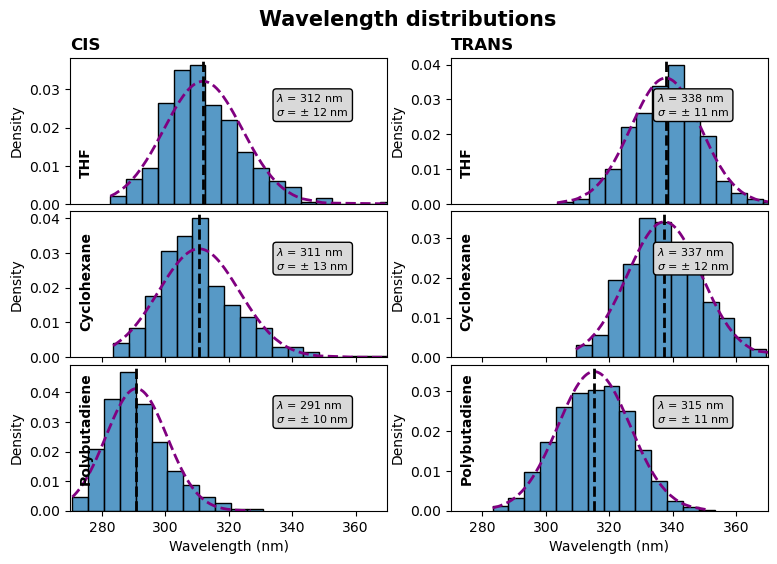

In [21]:
fig, ax = plt.subplots(nrows=3, ncols=2)

fig.subplots_adjust(hspace=0.05, wspace=0.2)

fig.suptitle(
    "Wavelength distributions",
    fontweight="bold",
    fontsize=15,
    y=0.96
)

names = ["CIS", "TRANS"]
solvent = ["THF", "Cyclohexane", "Polybutadiene"]

for i, iso in enumerate(names):
    ax[0, i].set_title(iso, horizontalalignment="left", fontweight="bold", loc="left")
    ax[0, i].get_xaxis().set_visible(False)

    for j, sol in enumerate(solvent):
        ax[j, i].text(
            0.05, 0.2, sol, transform=ax[j,i].transAxes, ha="center", fontweight="bold", rotation=90)
        
        wls = dataW[sol][iso.lower()]["s2"].copy()
        sns.histplot(x=wls, binwidth=5.0, stat="density", ax=ax[j,i])
        sns.lineplot(x=wls, y=dnorm(wls), ax=ax[j,i], color="purple", ls="--", lw=2.)
        ax[j, i].axvline(x=wls.mean(), ls="--", lw=2, color="k")
        ax[j, i].text(0.65, 0.6,
            f"$\lambda$ = {wls.mean():.0f} nm\n$\sigma$ = $\pm$ {wls.std():.0f} nm",
            transform=ax[j, i].transAxes,
            bbox=boxText, fontsize=8,
            ha="left")
        ax[j, i].set_xlabel("Wavelength (nm)")
        ax[j, i].set_xlim(270, 370)
        

# plt.savefig("distributions_lambda_max.png", dpi=300)
plt.show()

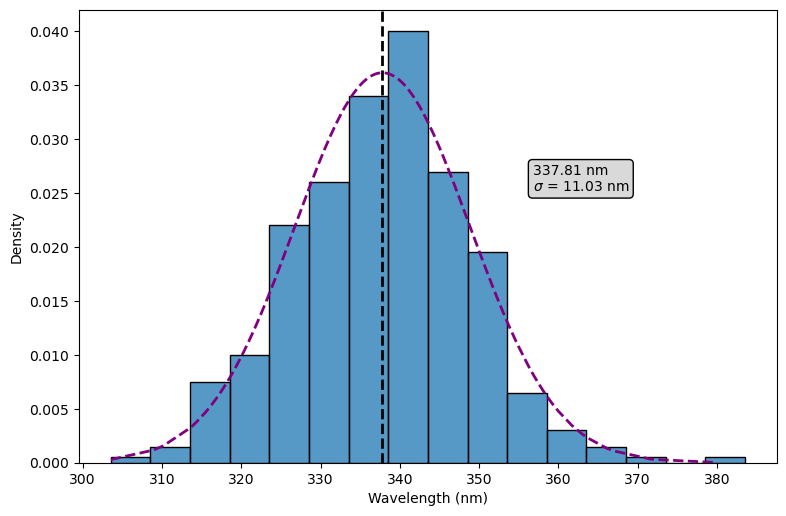

In [73]:
fig, ax = plt.subplots()

waves = trans_thf_w_s2.copy()

sns.histplot(x=waves, binwidth=5.0, stat="density", ax=ax)
sns.lineplot(x=waves, y=dnorm(waves), ax=ax, color="purple", ls="--", lw=2.)
ax.axvline(x=waves.mean(), ls="--", lw=2, color="k")

ax.text(0.65, 0.6,
        f"{waves.mean():.2f} nm\n$\sigma$ = {waves.std():.2f} nm",
        transform=ax.transAxes,
        bbox=boxText,
        ha="left")


ax.set_xlabel("Wavelength (nm)")

plt.show()

In [74]:
# Experimental data
trans_exp = pd.read_csv("../UV-cis.csv", header=None, names=["wl", "abs", "2", "3"])
cis_exp = pd.read_csv("../UV-trans.csv", header=None, names=["wl", "abs", "2", "3"])

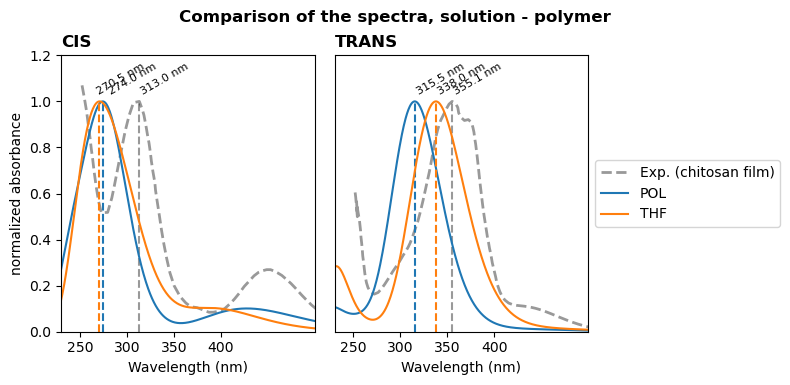

In [94]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

fig.suptitle(
    "Comparison of the spectra, solution - polymer", fontweight="bold", y=0.95
)

# CIS

## EXP
cis_exp_wl = cis_exp["wl"][cis_exp["abs"] == cis_exp["abs"][cis_exp["wl"] > 300.].max()].iloc[0]
ax[0].plot(
    cis_exp["wl"], cis_exp["abs"]/cis_exp["abs"][cis_exp["wl"] > 300].max(),
    color="k",
    alpha=0.4,
    ls="--",
    lw=2.0,
    label="Exp. (chitosan film)"
)

ax[0].vlines(cis_exp_wl, ymin=0, ymax=1, ls="--", color="k", alpha=0.4)
ax[0].text(
    cis_exp_wl, 1.03,
    "{:.1f} nm".format(cis_exp_wl),
    fontsize=8,
    ha="left",
    rotation=30
)

# POL
ax[0].plot(
    w_nm,
    cis_pol_spectra / cis_pol_spectra.max(),
    label="POL",
    color="tab:blue"
)

cis_pol_wl = w_nm[np.where(cis_pol_spectra == cis_pol_spectra.max())][0]
ax[0].vlines(cis_pol_wl, ymin=0, ymax=1, ls="--", color="tab:blue")
ax[0].text(
    cis_pol_wl+5., 1.03,
    "{:.1f} nm".format(cis_pol_wl),
    fontsize=8,
    ha="left",
    rotation=30
)

# THF
ax[0].plot(
    w_nm,
    cis_thf_spectra / cis_thf_spectra.max(),
    label="THF",
    color="tab:orange"
)

cis_thf_wl = w_nm[np.where(cis_thf_spectra == cis_thf_spectra.max())][0]
ax[0].vlines(cis_thf_wl, ymin=0, ymax=1, ls="--", color="tab:orange")
ax[0].text(
    cis_thf_wl-5., 1.03,
    "{:.1f} nm".format(cis_thf_wl),
    fontsize=8,
    ha="left",
    rotation=30
)


# TRANS
# EXP
trans_exp_wl = trans_exp["wl"][trans_exp["abs"] == trans_exp["abs"][trans_exp["wl"] > 300.].max()].iloc[0]
ax[1].plot(
    trans_exp["wl"], trans_exp["abs"]/trans_exp["abs"][trans_exp["wl"] > 300].max(),
    color="k",
    alpha=0.4,
    ls="--",
    lw=2.0,
    label="Exp. (chitosan film)"
)

ax[1].vlines(trans_exp_wl, ymin=0, ymax=1, ls="--", color="k", alpha=0.4)
ax[1].text(
    trans_exp_wl, 1.03,
    "{:.1f} nm".format(trans_exp_wl),
    fontsize=8,
    ha="left",
    rotation=30
)

# POL
ax[1].plot(
    w_nm,
    trans_pol_spectra / trans_pol_spectra.max(),
    label="POL",
    color="tab:blue"
)

trans_pol_wl = w_nm[np.where(trans_pol_spectra == trans_pol_spectra.max())][0]
ax[1].vlines(trans_pol_wl, ymin=0, ymax=1, ls="--", color="tab:blue")
ax[1].text(
    trans_pol_wl, 1.03,
    "{:.1f} nm".format(trans_pol_wl),
    fontsize=8,
    ha="left",
    rotation=30
)

# THF
ax[1].plot(
    w_nm,
    trans_thf_spectra / trans_thf_spectra.max(),
    label="THF",
    color="tab:orange"
)
trans_thf_wl = w_nm[np.where(trans_thf_spectra == trans_thf_spectra.max())][0]
ax[1].vlines(trans_thf_wl, ymin=0, ymax=1, ls="--", color="tab:orange")
ax[1].text(
    trans_thf_wl, 1.03,
    "{:.1f} nm".format(trans_thf_wl),
    fontsize=8,
    ha="left",
    rotation=30
)

ax[1].get_yaxis().set_visible(False)

isomer = ["CIS", "TRANS"]
for i, a in enumerate(ax):
    a.set_xlim(230,500)
    a.set_ylim(0,1.2)
    a.set_ylabel("normalized absorbance")
    a.set_xlabel("Wavelength (nm)")
    a.xaxis.set_ticks(np.arange(250, 450, 50))
    a.set_title(isomer[i], horizontalalignment="left", fontweight="bold", loc="left")
    
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

## Geometry DATA

In [23]:
from stamptools.analysis import load_log

In [24]:
def get_geom(folder):
    frame_in_time = load_log(f"{folder}/Stamp.log")
    dih = pd.read_csv(
        f"{folder}/Geometry_mol.csv",
        index_col=0
    )
    
    dih["time"] = frame_in_time["time"]
    
    return dih

def get_geom_gmx(folder):
    dih = pd.read_csv(
        f"{folder}/Geometry_mol.csv",
        index_col=0
    )
    
    # dih.drop(index=0, inplace=True)
    dih["time"] = np.arange(0, 10001, 1.)
    
    return dih

In [25]:
geom_cis_pol_0 = get_geom("../azoC_procedure/6_prod_0")
geom_trans_pol_0 = get_geom("../azoT_procedure/6_prod_0")
geom_cis_pol_0_long = get_geom("../azoC_procedure/6_prod_0_long")
geom_trans_pol_0_long = get_geom("../azoT_procedure/6_prod_0_long")

Reading log file - done in 3.43 s
Reading log file - done in 3.41 s
Reading log file - done in 13.37 s
Reading log file - done in 11.33 s


In [38]:
geom_cis_chx = get_geom_gmx("../exp.azobO.thf/azob_cis.chx/md")
geom_trans_chx = get_geom_gmx("../exp.azobO.thf/azob_trans.chx/md")

In [28]:
geom_cis_thf = get_geom_gmx("../exp.azobO.thf/azob_cis.thf/md")
geom_trans_thf = get_geom_gmx("../exp.azobO.thf/azob_trans.thf/md")

In [29]:
geom_cis_pol = pd.concat([geom_cis_pol_0, geom_cis_pol_0_long], ignore_index=True)
geom_trans_pol = pd.concat([geom_trans_pol_0, geom_trans_pol_0_long], ignore_index=True)

In [3]:
geom_cis_pol_0 = pd.read_csv("../azoC_procedure/6_prod_0/Geometry_mol.csv", index_col=0)
geom_trans_pol_0 = pd.read_csv("../azoT_procedure/6_prod_0/Geometry_mol.csv", index_col=0)
geom_cis_pol_1 = pd.read_csv("../azoC_procedure/6_prod_1/Geometry_mol.csv", index_col=0)
geom_trans_pol_1 = pd.read_csv("../azoT_procedure/6_prod_1/Geometry_mol.csv", index_col=0)
geom_cis_pol_2 = pd.read_csv("../azoC_procedure/6_prod_2/Geometry_mol.csv", index_col=0)
geom_trans_pol_2 = pd.read_csv("../azoT_procedure/6_prod_2/Geometry_mol.csv", index_col=0)
geom_cis_pol_3 = pd.read_csv("../azoC_procedure/6_prod_3/Geometry_mol.csv", index_col=0)
geom_trans_pol_3 = pd.read_csv("../azoT_procedure/6_prod_3/Geometry_mol.csv", index_col=0)
geom_cis_pol_4 = pd.read_csv("../azoC_procedure/6_prod_4/Geometry_mol.csv", index_col=0)
geom_trans_pol_5 = pd.read_csv("../azoT_procedure/6_prod_4/Geometry_mol.csv", index_col=0)

geom_cis_thf = pd.read_csv("../exp.azobO.thf/azob_cis.thf/md/Geometry_mol.csv", index_col=0)
geom_trans_thf = pd.read_csv("../exp.azobO.thf/azob_trans.thf/md/Geometry_mol.csv", index_col=0)

In [4]:
geom_cis_wt = pd.read_csv("../exp.azobO.thf/azob_cis.water/md/Geometry_mol.csv", index_col=0)
geom_trans_wt = pd.read_csv("../exp.azobO.thf/azob_trans.water/md/Geometry_mol.csv", index_col=0)

In [5]:
geom_cis_pol_0_long = pd.read_csv("../azoC_procedure/6_prod_0_long/Geometry_mol.csv", index_col=0)
geom_trans_pol_0_long = pd.read_csv("../azoT_procedure/6_prod_0_long/Geometry_mol.csv", index_col=0)

In [6]:
geom_cis_pol = pd.concat([geom_cis_pol_0, geom_cis_pol_0_long], ignore_index=True)
geom_trans_pol = pd.concat([geom_trans_pol_0, geom_trans_pol_0_long], ignore_index=True)

In [7]:
geom_cis_pol_0.columns

Index(['r_cc', 'r_ar_1', 'r_ar_2', 'd_cnnc', 'd_ccnn_1', 'd_ccnn_2',
       'd_ccnn_3', 'd_ccnn_4'],
      dtype='object')

In [30]:
geom_cis_pol

,r_cc,r_ar_1,r_ar_2,d_cnnc,d_ccnn_1,d_ccnn_2,d_ccnn_3,d_ccnn_4,time
0,2.518910,3.079505,3.727471,4.334823,83.054184,-114.095047,-93.323326,103.020256,82.51
1,2.533656,3.411418,3.169693,3.399356,83.683960,-103.957130,-116.739693,76.586426,85.01
2,2.451573,3.229898,3.444522,2.564262,79.494690,-131.924805,-116.682358,76.373032,87.51
3,2.484744,3.192036,3.395831,4.952167,93.337517,-105.155464,-97.175392,93.033607,90.01
4,2.706643,3.395793,3.544690,7.149346,73.959740,-119.305138,-112.010452,64.661476,92.51
...,...,...,...,...,...,...,...,...,...
3975,2.747575,3.632477,3.456652,18.741068,59.309551,-125.060753,-128.745224,53.089195,10020.00
3976,2.724359,3.905687,3.605050,15.069641,54.520412,-140.129532,-154.343323,45.496552,10020.00
3977,2.743611,3.903248,3.496887,8.107324,66.192482,-126.282539,-133.661469,50.037415,10030.00
3978,2.703052,3.520722,3.803504,8.575395,53.119839,-139.138977,-132.605591,62.841404,10030.00


In [8]:
data = {
    "CIS": {
        "THF": geom_cis_thf,
        "Polybutadiene": geom_cis_pol,
        "Cyclohexane": geom_cis_chx
    },
    "TRANS": {
        "THF": geom_trans_thf,
        "Cyclohexane": geom_trans_chx
    }
    
}

dataColors = {
    "CIS": {
        "THF": "#1c7b7f",
        "Polybutadiene": "#a953a7",
        "Cyclohexane": "#c356fd"
    },
    "TRANS": {
        "THF": "#b9e7e9",
        "Polybutadiene": "#e2623f",
        "Cyclohexane": "#abc790"
    }
    
}

In [16]:
def rot(x):
    if x < 0:
        return x + 360
    else:
        return x

In [21]:
geom_trans_pol["d_ccnn_1"][geom_trans_pol["time"] > 2000] = geom_trans_pol["d_ccnn_1"][geom_trans_pol["time"] > 2000].apply(rot)

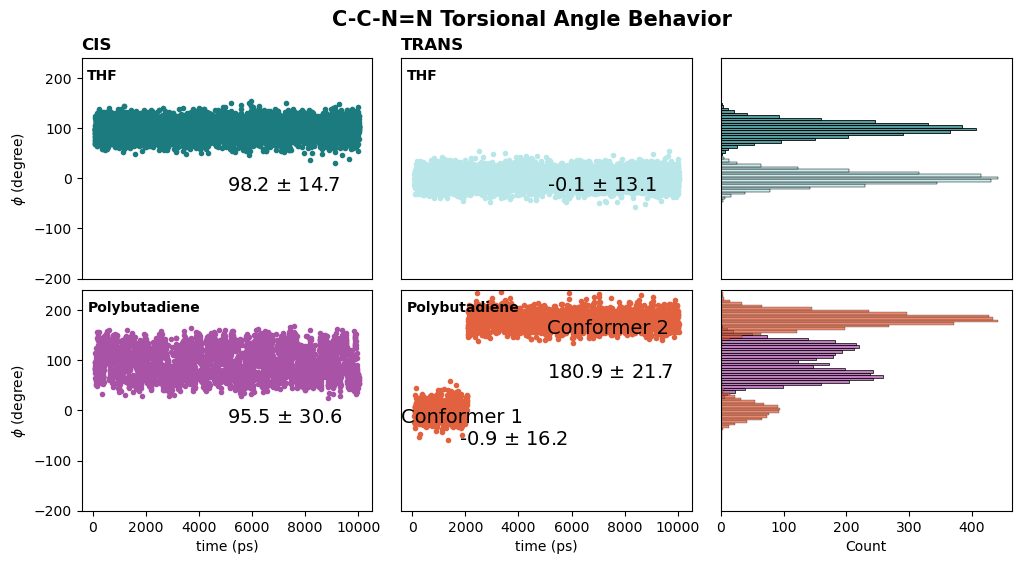

In [24]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[12, 6])

fig.subplots_adjust(hspace=0.05, wspace=0.1)

fig.suptitle(
    "C-C-N=N Torsional Angle Behavior",
    fontweight="bold",
    fontsize=15,
    y=0.96
)

names = ["CIS", "TRANS"]
solvent = ["THF", "Polybutadiene"]

for i, iso in enumerate(names):
    ax[0, i].set_title(iso, horizontalalignment="left", fontweight="bold", loc="left")
    ax[0, i].get_xaxis().set_visible(False)
    for j, sol in enumerate(solvent):
        ax[j, i].text(
            0.02, 0.9, sol, transform=ax[j,i].transAxes, ha="left", fontweight="bold", rotation=0)

        dat = data[iso][sol].copy()
        ax[j, i].plot(dat["time"], dat["d_ccnn_1"], ".", color=dataColors[iso][sol])
        
        if i == 0:
            ax[j, i].text(
                0.5, 0.4, "{:.1f} $\pm$ {:.1f}".format(dat["d_ccnn_1"].mean(), dat["d_ccnn_1"].std()),
                transform=ax[j,i].transAxes, ha="left", rotation=0, fontsize=14
            )
        if i == 1:
            if j == 0:
                ax[j, i].text(
                    0.5, 0.4,
                    "{:.1f} $\pm$ {:.1f}".format(dat["d_ccnn_1"].mean(),dat["d_ccnn_1"].std()),
                    transform=ax[j,i].transAxes, ha="left", rotation=0, fontsize=14
                )
                
            if j == 1:
                dat1 = dat["d_ccnn_1"][dat["time"] < 2000]
                ax[j, i].text(
                    0.2, 0.3,
                    "{:.1f} $\pm$ {:.1f}".format(dat1.mean(),dat1.std()),
                    transform=ax[j,i].transAxes, ha="left", rotation=0, fontsize=14
                )
                dat2 = dat["d_ccnn_1"][dat["time"] > 2000]
                ax[j, i].text(
                    0.5, 0.6,
                    "{:.1f} $\pm$ {:.1f}".format(dat2.mean(),dat2.std()),
                    transform=ax[j,i].transAxes, ha="left", rotation=0, fontsize=14
                )
        
        ax[j, i].set_xlabel("time (ps)")
        if iso == "CIS":
            ax[j, i].set_ylim(-200, 240)
            ax[j, i].set_ylabel("$\phi$ (degree)")
        if iso == "TRANS":
            ax[j, i].set_ylim(-200, 240)
            ax[j, i].set_ylabel("$\phi$ (degree)")
            
            
        # ax[0, 2].set_title("Hola")
        sns.histplot(
            data=dat,
            y="d_ccnn_1",
            ax=ax[j, 2],
            color=dataColors[iso][sol], binwidth=5.0
        )

ax[0, 2].get_xaxis().set_visible(False)
ax[0, 2].set_ylim(-200, 240)
ax[1, 2].set_ylim(-200, 240)
ax[0, 2].get_yaxis().set_visible(False)
ax[1, 2].get_yaxis().set_visible(False)

ax[0, 1].get_yaxis().set_visible(False)
ax[1, 1].get_yaxis().set_visible(False)


ax[1, 1].text(
    0.0, 0.4, "Conformer 1", transform=ax[1,1].transAxes, ha="left", rotation=0, fontsize=14
            )

ax[1, 1].text(
    0.5, 0.8, "Conformer 2", transform=ax[1,1].transAxes, ha="left", rotation=0, fontsize=14
            )

#ax[1, 1].text(
#    0.5, 0.1, "Conformer 2", transform=ax[1,1].transAxes, ha="left", rotation=0, fontsize=14
#            )


"""
        ax[j, i].axvline(x=wls.mean(), ls="--", lw=2, color="k")
        ax[j, i].text(0.65, 0.6,
            f"$\lambda$ = {wls.mean():.2f} nm\n$\sigma$ $\pm$ {wls.std():.2f} nm",
            transform=ax[j, i].transAxes,
            bbox=boxText, fontsize=8,
            ha="left")


"""
plt.savefig("torsion_ccnn_inTime_dist.png", dpi=300)
plt.show()

'\nfor i, col in enumerate(geom_cis_pol_0.columns):\n    # sns.scatterplot(data=geom_cis_pol[col], ax=ax[i])\n    ax[i].plot(geom_cis_pol[col])\n    ax[i].plot(geom_cis_thf[col])\n    # sns.scatterplot(data=geom_cis_thf[col], ax=ax[i], marker="x")\n    ax[i].set_xlim(0, 4000)\n    ax[i].set_ylabel(col)\n'

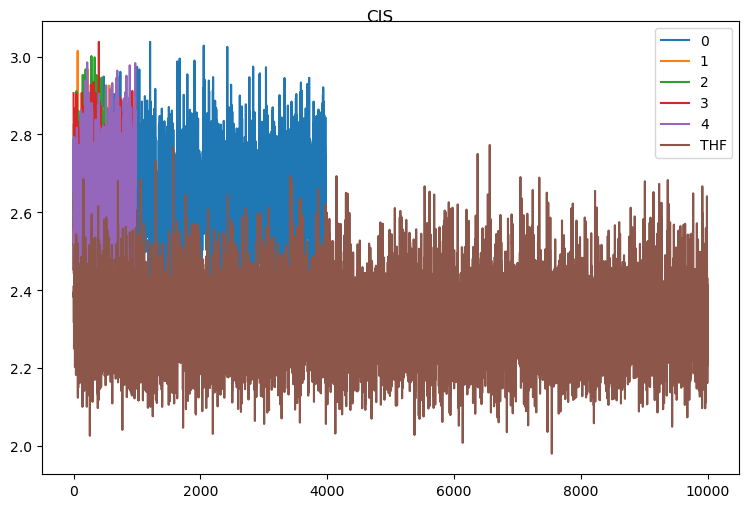

In [137]:
fig, ax = plt.subplots()

fig.suptitle("CIS", y=0.90)

for i,data in enumerate([geom_cis_pol, geom_cis_pol_1, geom_cis_pol_2, geom_cis_pol_3, geom_cis_pol_4]):
    ax.plot(data["r_cc"], label=str(i))

ax.plot(geom_cis_thf["r_cc"], label="THF")
ax.legend()
    
"""
for i, col in enumerate(geom_cis_pol_0.columns):
    # sns.scatterplot(data=geom_cis_pol[col], ax=ax[i])
    ax[i].plot(geom_cis_pol[col])
    ax[i].plot(geom_cis_thf[col])
    # sns.scatterplot(data=geom_cis_thf[col], ax=ax[i], marker="x")
    ax[i].set_xlim(0, 4000)
    ax[i].set_ylabel(col)
"""

In [45]:
geom_cis_pol.columns[:-1]

Index(['r_cc', 'r_ar_1', 'r_ar_2', 'd_cnnc', 'd_ccnn_1', 'd_ccnn_2',
       'd_ccnn_3', 'd_ccnn_4'],
      dtype='object')

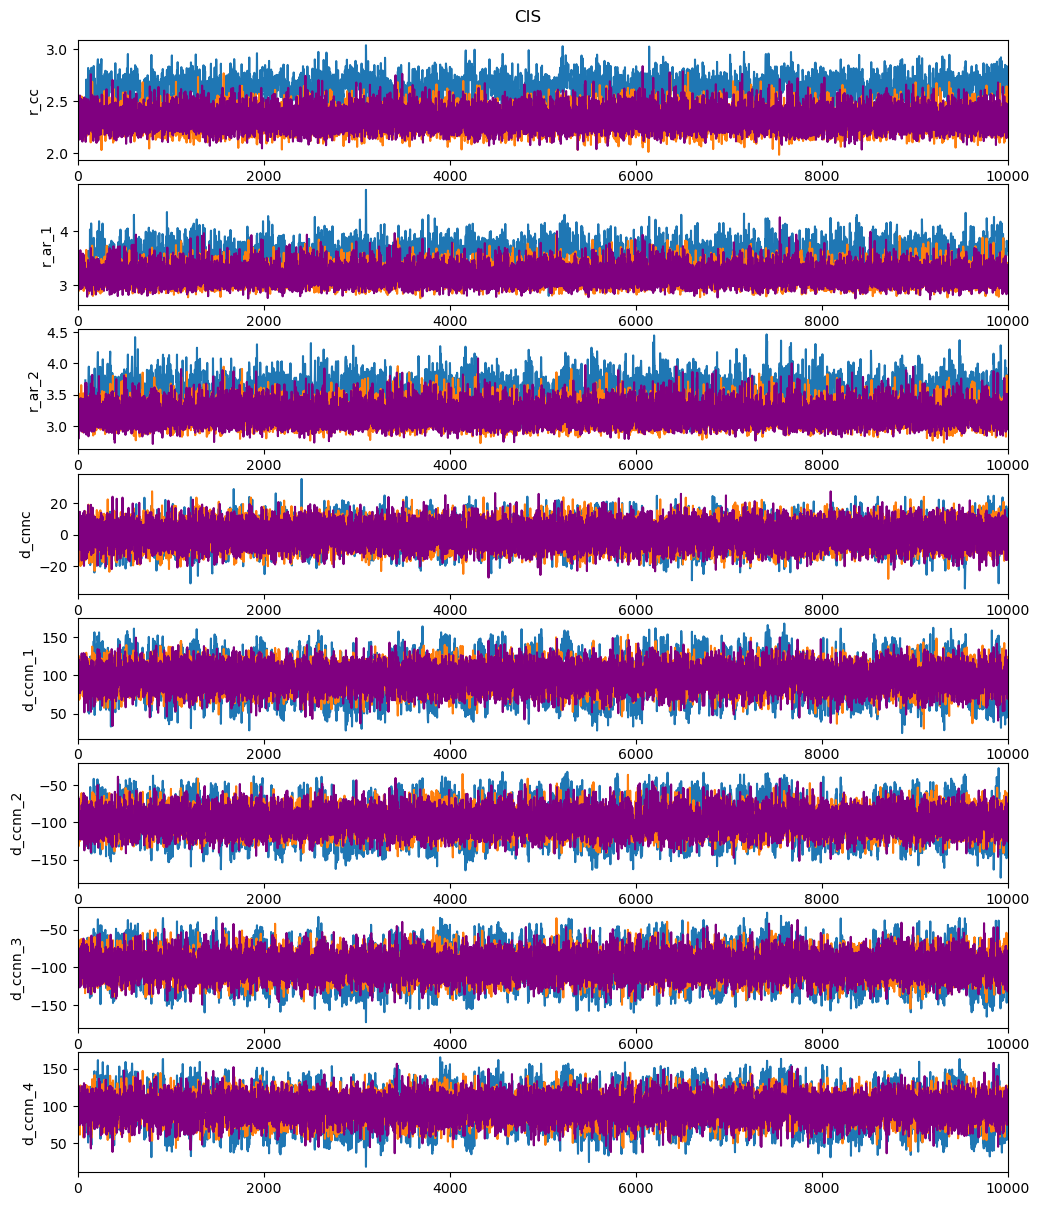

In [47]:
fig, ax = plt.subplots(nrows=len(geom_cis_pol.columns[:-1]), figsize=(12,15))

fig.suptitle("CIS", y=0.90)

for i, col in enumerate(['r_cc', 'r_ar_1', 'r_ar_2', 'd_cnnc', 'd_ccnn_1', 'd_ccnn_2', 'd_ccnn_3', 'd_ccnn_4']):
    # sns.scatterplot(data=geom_cis_pol[col], ax=ax[i])
    ax[i].plot(geom_cis_pol["time"], geom_cis_pol[col])
    ax[i].plot(geom_cis_thf["time"], geom_cis_thf[col])
    ax[i].plot(geom_cis_chx["time"], geom_cis_chx[col], "purple")
    # sns.scatterplot(data=geom_cis_thf[col], ax=ax[i], marker="x")
    ax[i].set_xlim(0, 10000)
    ax[i].set_ylabel(col)


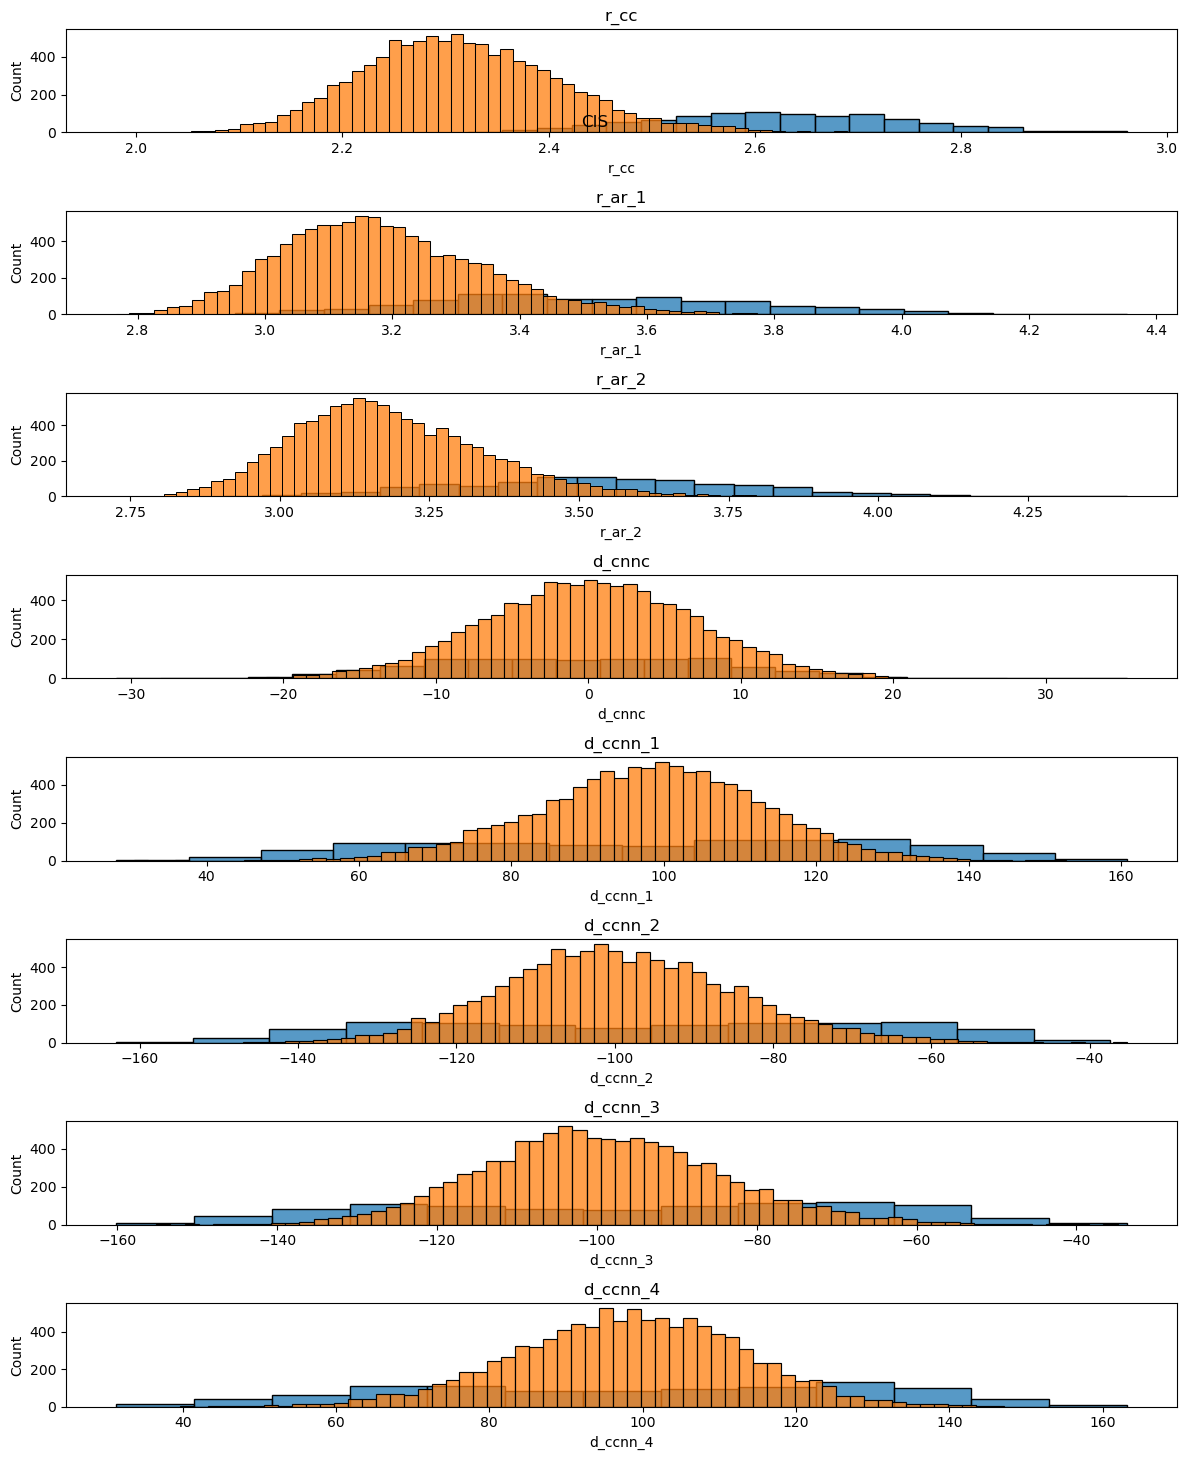

In [123]:
fig, ax = plt.subplots(nrows=8, figsize=(12,15))

fig.suptitle("CIS", y=0.90)

for i, col in enumerate(geom_cis_pol_0.columns):
    ax[i].set_title(col)
    sns.histplot(data=geom_cis_pol_0[col], ax=ax[i], color="tab:blue")
    sns.histplot(data=geom_cis_thf[col], ax=ax[i], color="tab:orange")
    
plt.tight_layout()

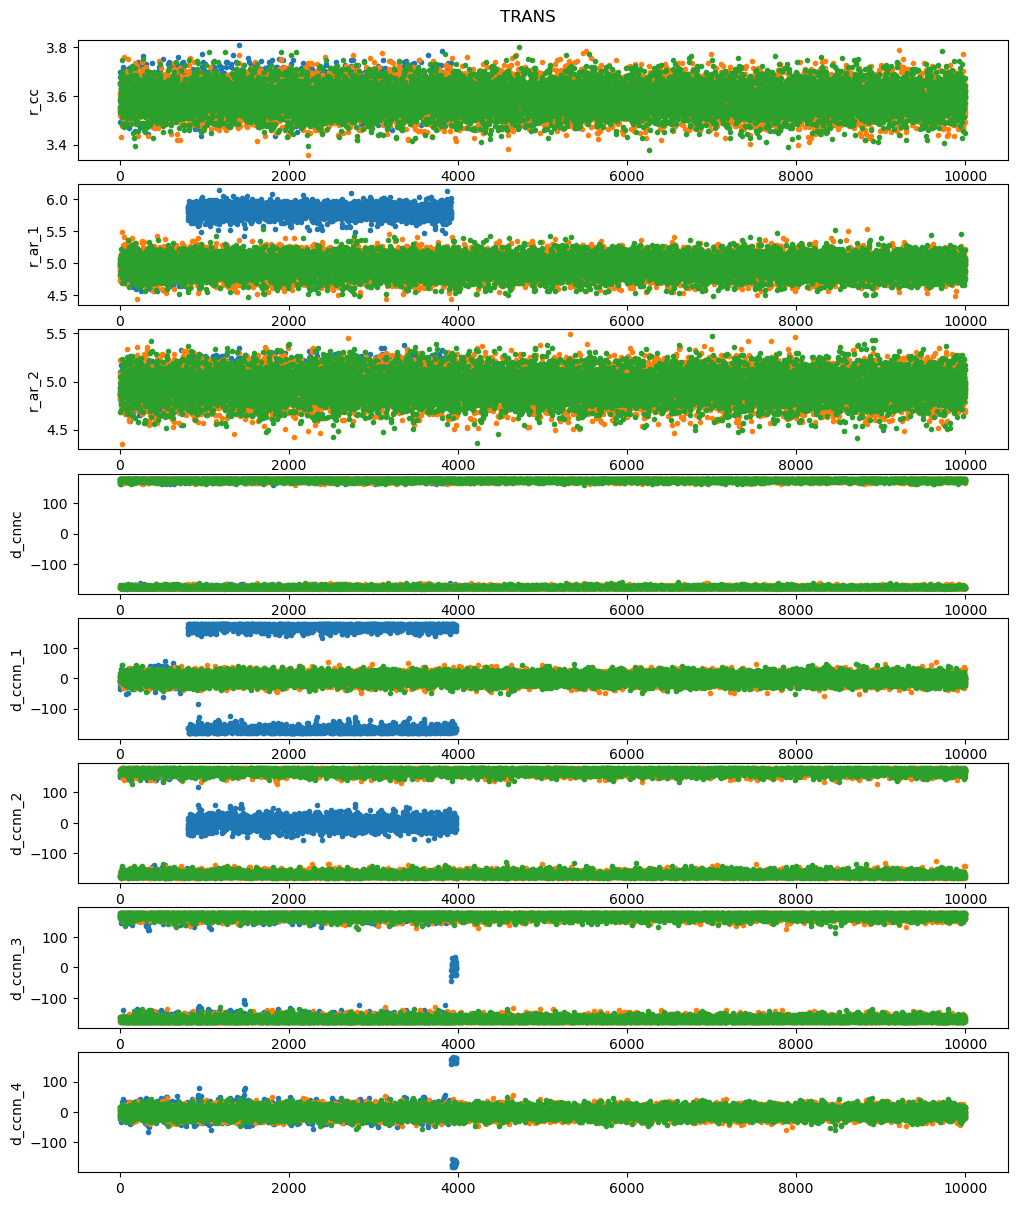

In [146]:
fig, ax = plt.subplots(nrows=8, figsize=(12,15))

fig.suptitle("TRANS", y=0.90)

for i, col in enumerate(geom_trans_pol_0.columns):
    # sns.scatterplot(data=geom_cis_pol[col], ax=ax[i])
    ax[i].plot(geom_trans_pol[col], ".")
    ax[i].plot(geom_trans_thf[col], ".")
    ax[i].plot(geom_trans_wt[col], ".")
    # sns.scatterplot(data=geom_cis_thf[col], ax=ax[i], marker="x")
    # ax[i].set_xlim(0, 4000)
    ax[i].set_ylabel(col)


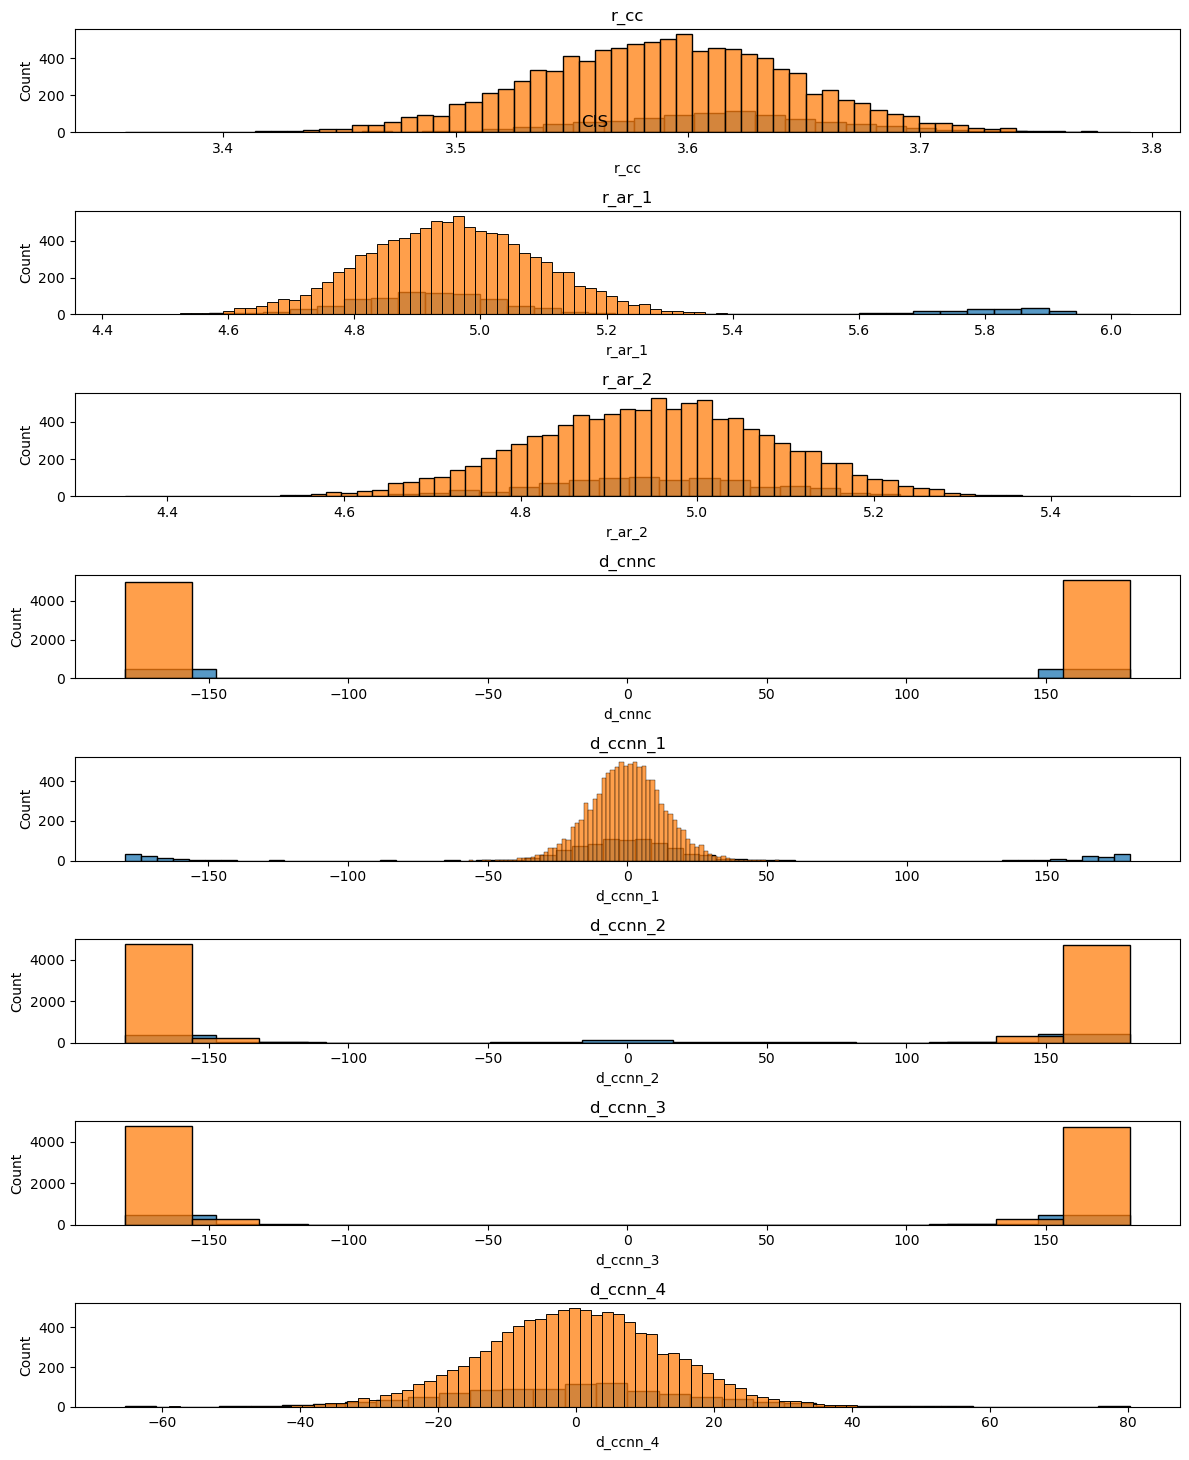

In [121]:
fig, ax = plt.subplots(nrows=8, figsize=(12,15))

fig.suptitle("CIS", y=0.90)

for i, col in enumerate(geom_trans_pol_0.columns):
    ax[i].set_title(col)
    sns.histplot(data=geom_trans_pol_0[col], ax=ax[i], color="tab:blue")
    sns.histplot(data=geom_trans_thf[col], ax=ax[i], color="tab:orange")
    
plt.tight_layout()

'\nfor i, col in enumerate(geom_cis_pol_0.columns):\n    # sns.scatterplot(data=geom_cis_pol[col], ax=ax[i])\n    ax[i].plot(geom_cis_pol[col])\n    ax[i].plot(geom_cis_thf[col])\n    # sns.scatterplot(data=geom_cis_thf[col], ax=ax[i], marker="x")\n    ax[i].set_xlim(0, 4000)\n    ax[i].set_ylabel(col)\n'

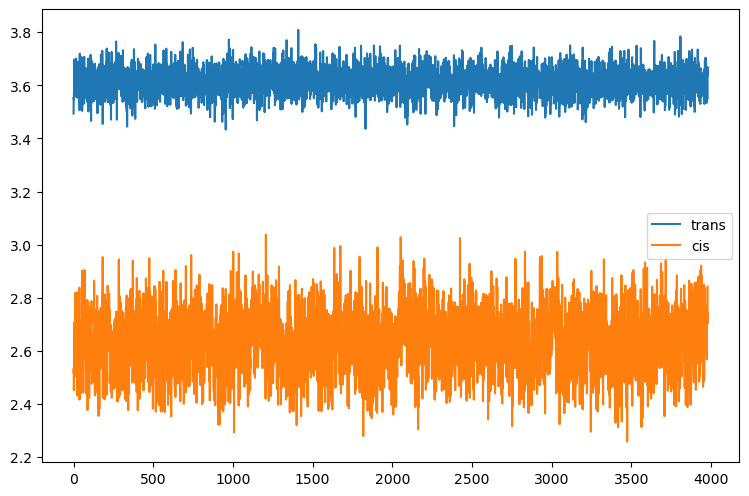

In [143]:
fig, ax = plt.subplots()

# fig.suptitle("CIS", y=0.90)

# for i,data in enumerate([geom_cis_pol, geom_cis_pol_1, geom_cis_pol_2, geom_cis_pol_3, geom_cis_pol_4]):
#     ax.plot(data["r_cc"], label=str(i))

ax.plot(geom_trans_pol["r_cc"], label="trans")
ax.plot(geom_cis_pol["r_cc"], label="cis")
ax.legend()
    
"""
for i, col in enumerate(geom_cis_pol_0.columns):
    # sns.scatterplot(data=geom_cis_pol[col], ax=ax[i])
    ax[i].plot(geom_cis_pol[col])
    ax[i].plot(geom_cis_thf[col])
    # sns.scatterplot(data=geom_cis_thf[col], ax=ax[i], marker="x")
    ax[i].set_xlim(0, 4000)
    ax[i].set_ylabel(col)
"""

In [147]:
from stamptools.analysis import load_data

In [148]:
cis_0 = load_data("../azoC_procedure/6_prod_0/Stamp.dat")

In [149]:
cis_0_long = load_data("../azoC_procedure/6_prod_0_long/Stamp.dat")

In [150]:
cis = pd.concat([cis_0, cis_0_long])

In [151]:
cis

,time,Etot,Epot,Epot_intra,Epot_inter,Ekin,T,Tx,Ty,Tz,P,Px,Py,Pz,Vx,Vy,Vz,D,cpu
0,80.001000,5.774034,3.334881e-21,5.452160e-21,-2.117279e-21,6.253128e-21,301.919824,299.283354,302.463106,304.013012,-198.909086,-8.460173e+07,8.851919e+05,2.404382e+07,-1.301267,-6.024074,7.781782,0.0,-1.000000
1,80.261500,5.774124,3.315436e-21,5.429419e-21,-2.113983e-21,6.272722e-21,302.864956,300.692094,302.774418,305.128357,-735.262043,-1.029108e+08,-8.132323e+07,-3.634458e+07,0.045826,-7.091272,7.268421,0.0,0.155190
2,80.511500,5.822482,3.400775e-21,5.412779e-21,-2.012004e-21,6.267684e-21,302.625678,299.745474,303.688140,304.443421,-532.002433,-5.763553e+07,-7.271476e+07,-2.925044e+07,-1.931203,-7.287984,5.265510,0.0,0.155838
3,80.761500,5.729409,3.240188e-21,5.368071e-21,-2.127883e-21,6.273719e-21,302.921422,301.618282,303.935444,303.210541,-760.037357,-1.569110e+08,-4.649868e+07,-2.460152e+07,-4.161057,0.480704,6.866099,0.0,0.156001
4,81.011500,5.732584,3.330138e-21,5.357807e-21,-2.027669e-21,6.189041e-21,298.836110,295.783654,299.113236,301.611440,-666.142878,3.328867e+07,-1.795730e+08,-5.355853e+07,-2.956509,-0.459118,6.304641,0.0,0.153919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30300,10029.024494,5.752768,3.302363e-21,5.281828e-21,-1.979465e-21,6.250334e-21,301.796234,298.129710,302.158365,305.100628,-653.701553,-2.220305e+07,-4.776144e+07,-1.261460e+08,-0.481471,6.740032,-0.762932,0.0,0.178959
30301,10029.274494,5.828484,3.406337e-21,5.308050e-21,-1.901713e-21,6.272088e-21,302.845261,301.270633,303.386590,303.878560,-1015.254187,-1.105071e+08,-9.585104e+07,-9.821807e+07,1.186142,7.052825,-1.226061,0.0,0.175830
30302,10029.524494,5.703160,3.237755e-21,5.338141e-21,-2.100386e-21,6.232566e-21,300.941333,299.465220,300.277252,303.081528,-539.299646,-3.541596e+07,-7.819050e+07,-4.818344e+07,1.754005,5.360134,-0.596323,0.0,0.188982
30303,10029.774494,5.763765,3.331008e-21,5.288632e-21,-1.957624e-21,6.239949e-21,301.282645,301.762507,299.533354,302.552072,7.832022,1.733947e+07,-4.378999e+07,2.880013e+07,6.655483,4.840379,-5.867427,0.0,0.184591


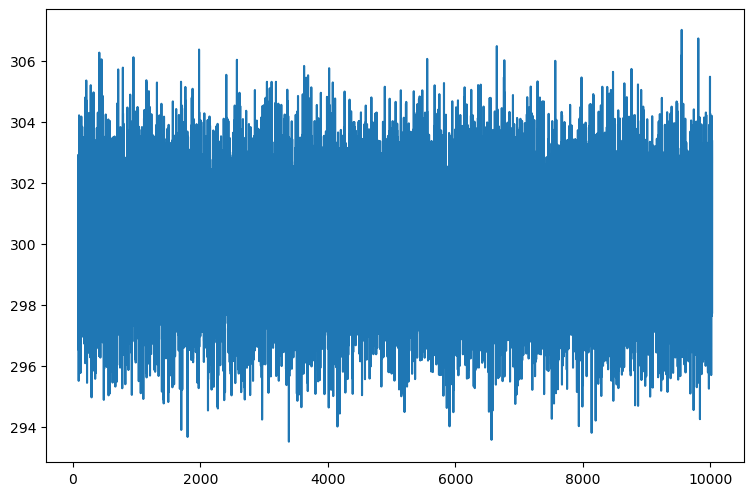

In [152]:
plt.plot(cis["time"], cis["T"])